# Population dynamics of clonal B cell lineages

In [87]:
import sys
import os
import time
import itertools
import copy

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

output_dir = "outs"
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name, output_dir, output_suffix, output_formats, savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.2}
mpl.rc('savefig', dpi=300)

sns.set_style("ticks")
sns.set_context("talk")

myColors = ["#E69F00", "#56B4E9"]
myColors_subjects = ['#e41a1c','#377eb8','#a6cee3','#984ea3','#f781bf']

# Load data

In [88]:
# Lineage dynamics data
# Sequences, molecules, and fractional abundances were calculated during preprocessing
df_all = pd.read_csv("data/df_ClonalLineageDynamics.csv", index_col=0)
print df_all.shape
df_all.head()

(169368, 30)


sequences_V1  molecules_V1  sequences_V2  molecules_V2  \
uid                                                                         
70201010000000001           9.0          30.0           1.0           6.0   
20201010000000001           0.0           0.0           2.0           4.0   
20201010000000267           1.0           3.0           4.0          10.0   
80201010000000116          44.0         550.0          61.0         924.0   
60201010000000781           0.0           0.0           0.0           0.0   

                   sequences_V3  molecules_V3  sequences_V4  molecules_V4  \
uid                                                                         
70201010000000001           2.0           5.0           2.0           5.0   
20201010000000001           1.0           1.0           6.0          59.0   
20201010000000267           0.0           0.0           2.0           5.0   
80201010000000116          35.0         806.0          62.0         671.0   
60201010000000781           7.0          20.0           3.0           4.0   

                   sequences_V5  molecules_V5     ...       \
uid                                               ...        
70201010000000001           2.0          10.0     ...        
20201010000000001           0.0           0.0     ...        
20201010000000267           9.0          29.0     ...        
80201010000000116          22.0         135.0     ...        
60201010000000781           0.0           0.0     ...        

                   sequences_V2_normed  sequences_V3_normed  \
uid                                                           
70201010000000001             0.000139             0.000382   
20201010000000001             0.000034             0.000019   
20201010000000267             0.000068             0.000000   
80201010000000116             0.001673             0.001126   
60201010000000781             0.000000             0.000274   

                   sequences_V4_normed  sequences_V5_normed  \
uid                                                           
70201010000000001             0.000790             0.000151   
20201010000000001             0.000159             0.000000   
20201010000000267             0.000053             0.000189   
80201010000000116             0.001980             0.000614   
60201010000000781             0.000100             0.000000   

                   sequences_V6_normed  sequences_V7_normed  \
uid                                                           
70201010000000001             0.324309             0.000000   
20201010000000001             0.084574             0.026856   
20201010000000267             0.066906             0.021466   
80201010000000116             0.050562             0.000766   
60201010000000781             0.050069             0.021324   

                   sequences_V8_normed  V3_V1_ratio  onset  V6_V3_ratio  
uid                                                                      
70201010000000001             0.000313     0.681657      0   848.554106  
20201010000000001             0.005361          inf      1  4364.622308  
20201010000000267             0.006024     0.000000      0          inf  
80201010000000116             0.001709     1.286020      0    44.900616  
60201010000000781             0.002521          inf      2   183.023279  

[5 rows x 30 columns]

# Visualize dynamics of entire repertoire (largest lineages)

In [89]:
# Define functions for plotting

def rename_days(data):
    """ Replace names of columns with days """
    col_names = ["sequences_V" + str(x) + "_normed" for x in range(1, 9)]
    days = [-5, -3, 0, 1, 4, 7, 9, 11]
    for col_name, day in zip(col_names, days):
        data[day] = data[col_name]
        data.drop(col_name, axis=1, inplace=True)
    return data

def stream_plot(df, ax, patient_uid, abundance_cutoff=None, num_lineages=None, subject_num="NA", linewidth=0):
    """ Make stream plot of fractional abundance data for a subject """
    
    col_names = ["sequences_V" + str(x) + "_normed" for x in range(1, 9)]

    # Get data
    N = num_lineages # number of lineages
    data = df[df["patient_uid"] == patient_uid]
    if abundance_cutoff is not None:
        data = data[data["sequences_V6_normed"] > abundance_cutoff] # filter for sequences >0.01% of repertoire at D7
    elif num_lineages is not None:
        data = data.sort_values(by="sequences_V6_normed", ascending=False)
        data = data.head(n=N)
    data = data.sort_values(by=["sequences_V6_normed"], ascending=True)

    # Sort lineages by onset time
    # data = data.sort_values(by=["onset", "sequences_V6_normed"], ascending=True)

    # Set days and colors
    X = [-5, -3, 0, 1, 4, 7, 9, 11] # days
    myOnsets = data["onset"]
    # myPal = sns.color_palette("RdYlBu_r", len(X)) 
    # myColors = [myPal[x] for x in myOnsets] # colored by onset
    
    # different color for each lineage
    myPal = itertools.cycle(sns.color_palette("Paired", 10))
    myColors = [next(myPal) for x in myOnsets]

    # Get columns to plot
    N = data.shape[0]
    data = data[col_names].head(n=N) * 100
    data = rename_days(data)
    
    print "Subject", patient_uid
    print "Lineages", N
    print "Fraction of repertoire at D7", np.sum(data[7])
    print    

    # Plot streamplot
    ax.stackplot(X, data, baseline="zero", colors=myColors, linewidth=linewidth)
    ax.set_xlim(left=-5, right=11)
    ax.yaxis.set_visible(True)
    ax.xaxis.set_visible(False)
    sns.despine(bottom=True)
    # label = "Subject " + str(subject_num) + ", " + str(N) + " lineages"
    # ax.text(-4.5, 45, label)
    plt.locator_params(axis='y', nbins=4)
    plt.tight_layout()
    
    return ax

Subject 2
Lineages 500
Fraction of repertoire at D7 83.1781457193

Subject 3
Lineages 500
Fraction of repertoire at D7 81.2409679587

Subject 6
Lineages 500
Fraction of repertoire at D7 86.177091263

Subject 7
Lineages 500
Fraction of repertoire at D7 91.3994765255

Subject 8
Lineages 500
Fraction of repertoire at D7 82.5



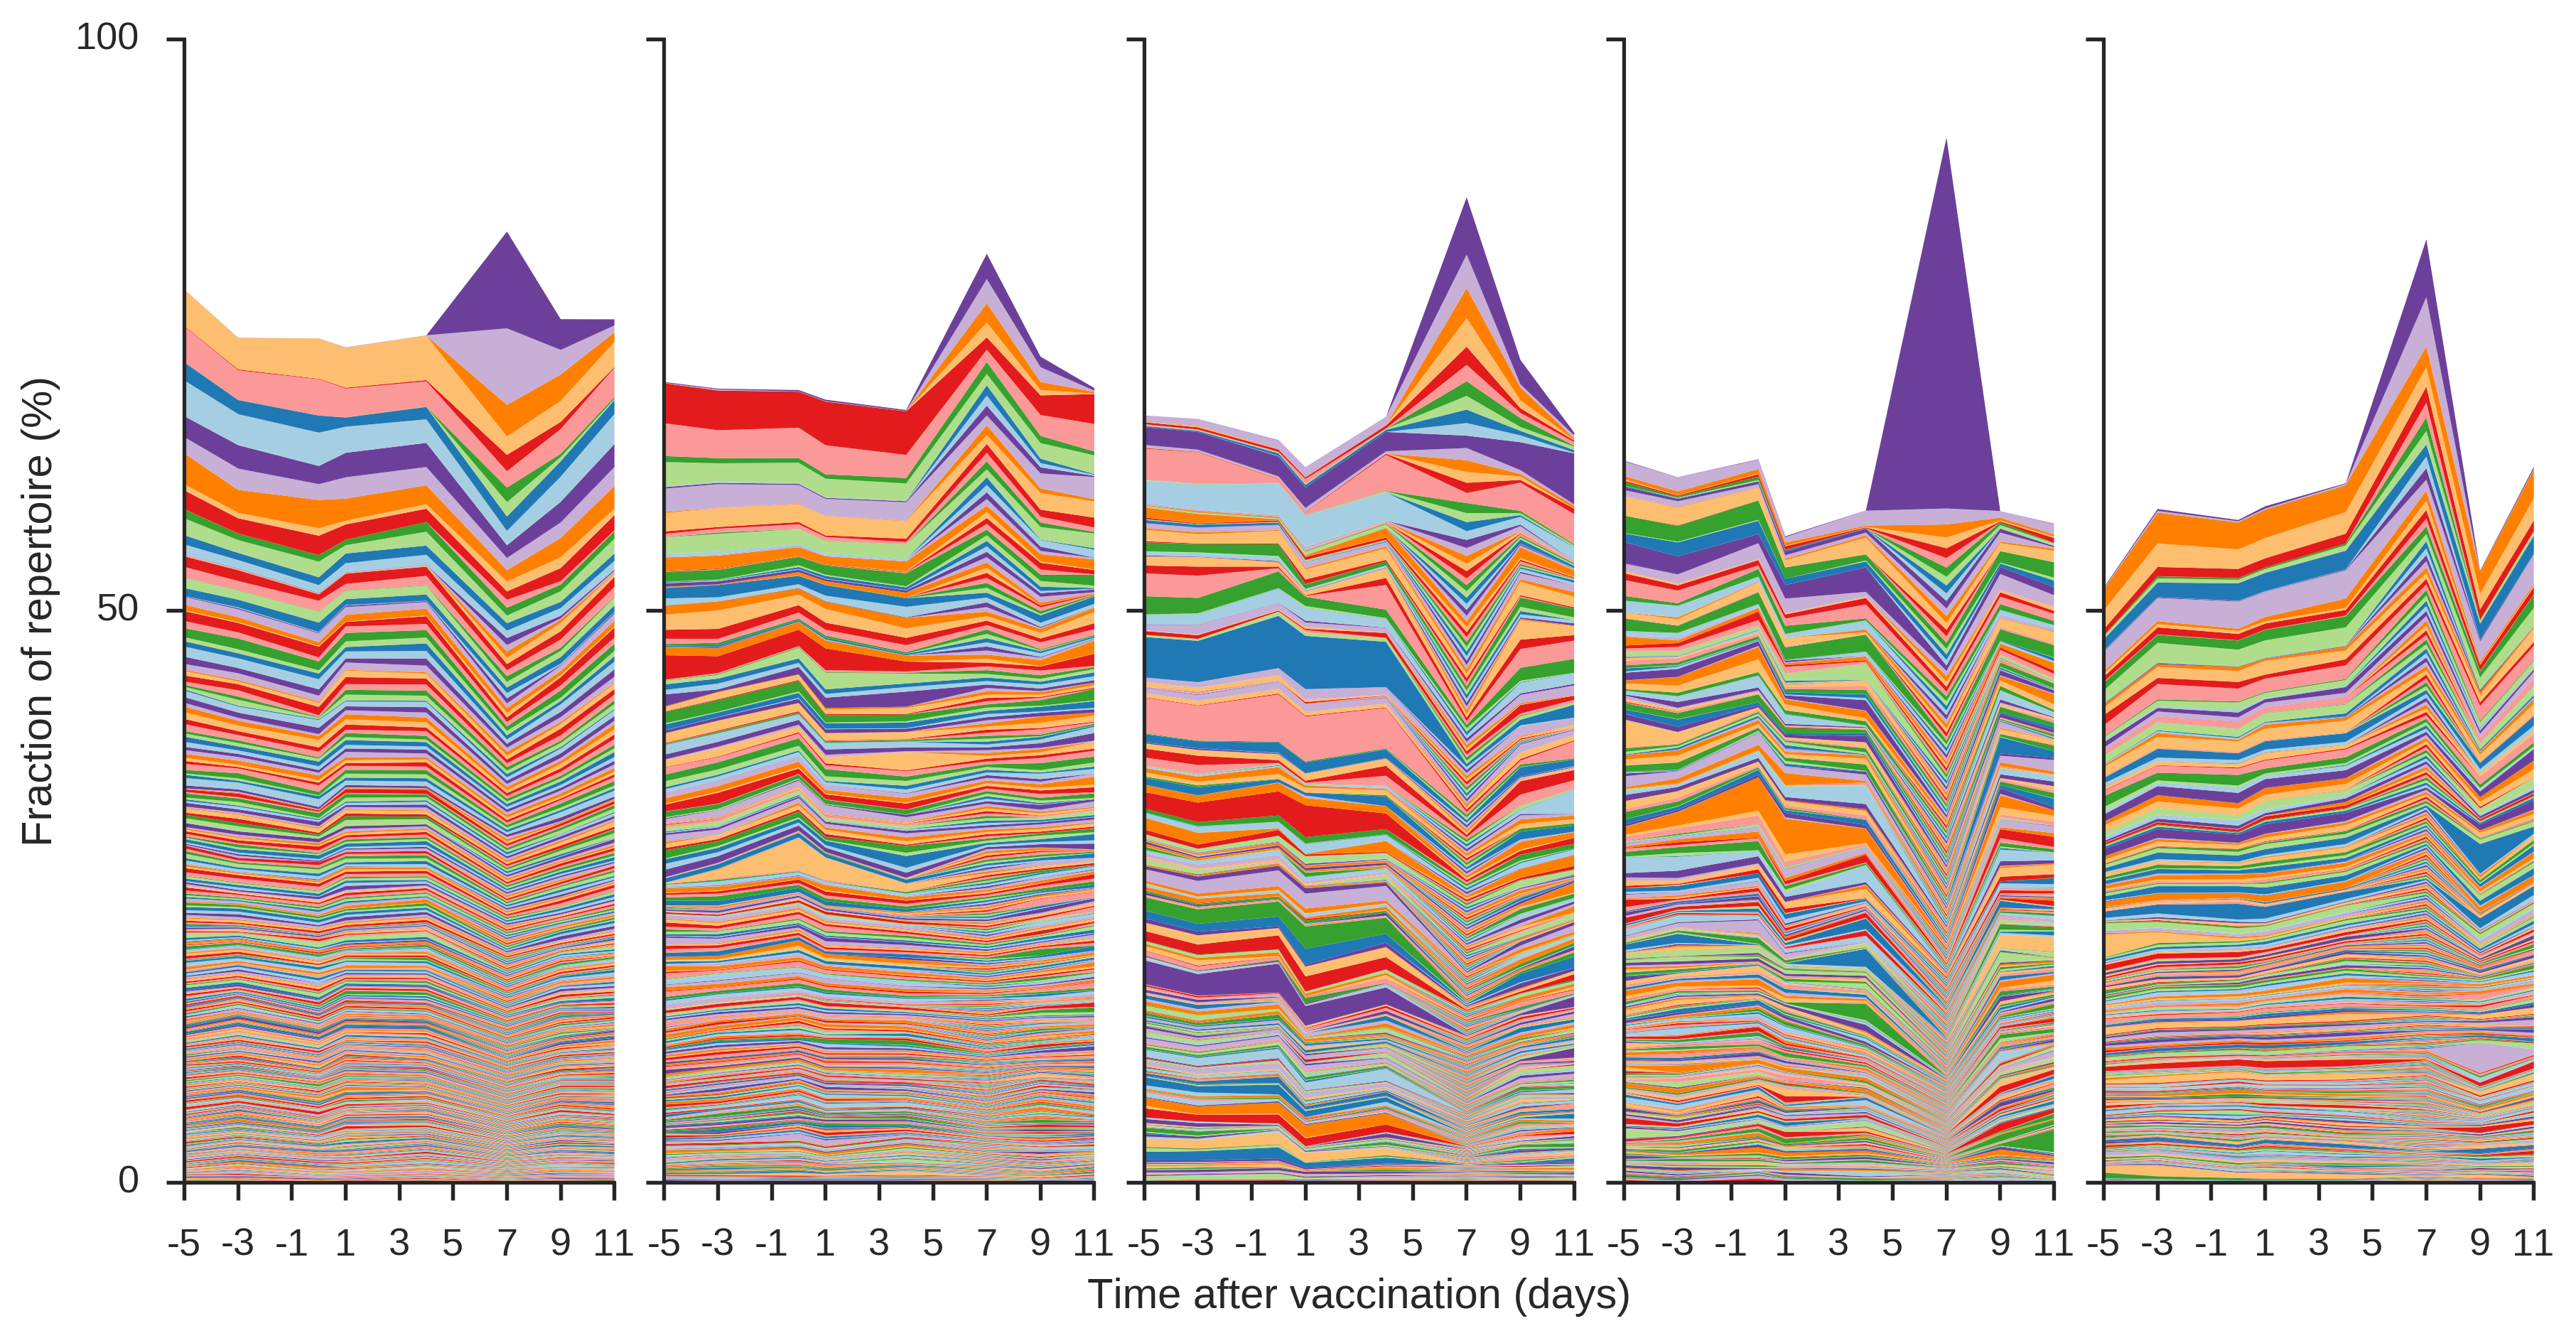

In [90]:
# Plot fractional abundances for all subjects

patient_uids = [2, 3, 6, 7, 8]

fig, axes = plt.subplots(1, 5, figsize=(12,6), sharey=True)

for i, (ax, patient_uid) in enumerate(zip(axes, patient_uids)):
    stream_plot(df_all, ax, patient_uid=patient_uid, num_lineages=500, subject_num=i+1, linewidth=0)
    
axes[0].set_ylabel("Fraction of repertoire (%)")
axes[2].set_xlabel("Time after vaccination (days)")

for ax in axes:
    ax.xaxis.set_visible(True)
    sns.despine(ax=ax, bottom=False)
    ax.set_xticks([-5, -3, -1, 1, 3, 5, 7, 9, 11])
    ax.set_xticklabels([-5, -3, -1, 1, 3, 5, 7, 9, 11])

# save_figure(fig, "ClonalLineageDynamics_prettyStream", output_dir, output_suffix, output_formats, savefig_args)

# Examine dynamics between baseline time points (to determine appropriate fold-change cutoff)

In [91]:
# Calculate ratio of D7 to D0
df_all["V6_V3_ratio"] = df_all["sequences_V6_normed"] / df_all["sequences_V3_normed"]

# Calculate ratio of D-5 to D-3
df_all["V3_V1_ratio"] = df_all["sequences_V3_normed"] / df_all["sequences_V1_normed"]

2      3      6      7      8
cutoff                                        
0.001000     183.0  201.0  169.0  233.0  193.0
0.002154     183.0  201.0  169.0  233.0  193.0
0.004642     183.0  201.0  169.0  233.0  193.0
0.010000     183.0  201.0  169.0  233.0  193.0
0.021544     183.0  201.0  169.0  233.0  193.0
0.046416     183.0  201.0  169.0  233.0  192.0
0.100000     183.0  201.0  169.0  233.0  192.0
0.215443     183.0  201.0  165.0  232.0  191.0
0.464159     181.0  198.0  158.0  215.0  187.0
1.000000      93.0  114.0  131.0  163.0  148.0
2.154435      12.0   37.0   19.0  102.0   46.0
4.641589       5.0   21.0    8.0   42.0   14.0
10.000000      2.0   12.0    6.0   25.0    6.0
21.544347      1.0   10.0    5.0   17.0    6.0
46.415888      NaN    8.0    5.0   13.0    5.0
100.000000     NaN    8.0    5.0   12.0    2.0
215.443469     NaN    7.0    5.0   12.0    2.0
464.158883     NaN    7.0    5.0   12.0    2.0
1000.000000    NaN    7.0    5.0   12.0    2.0

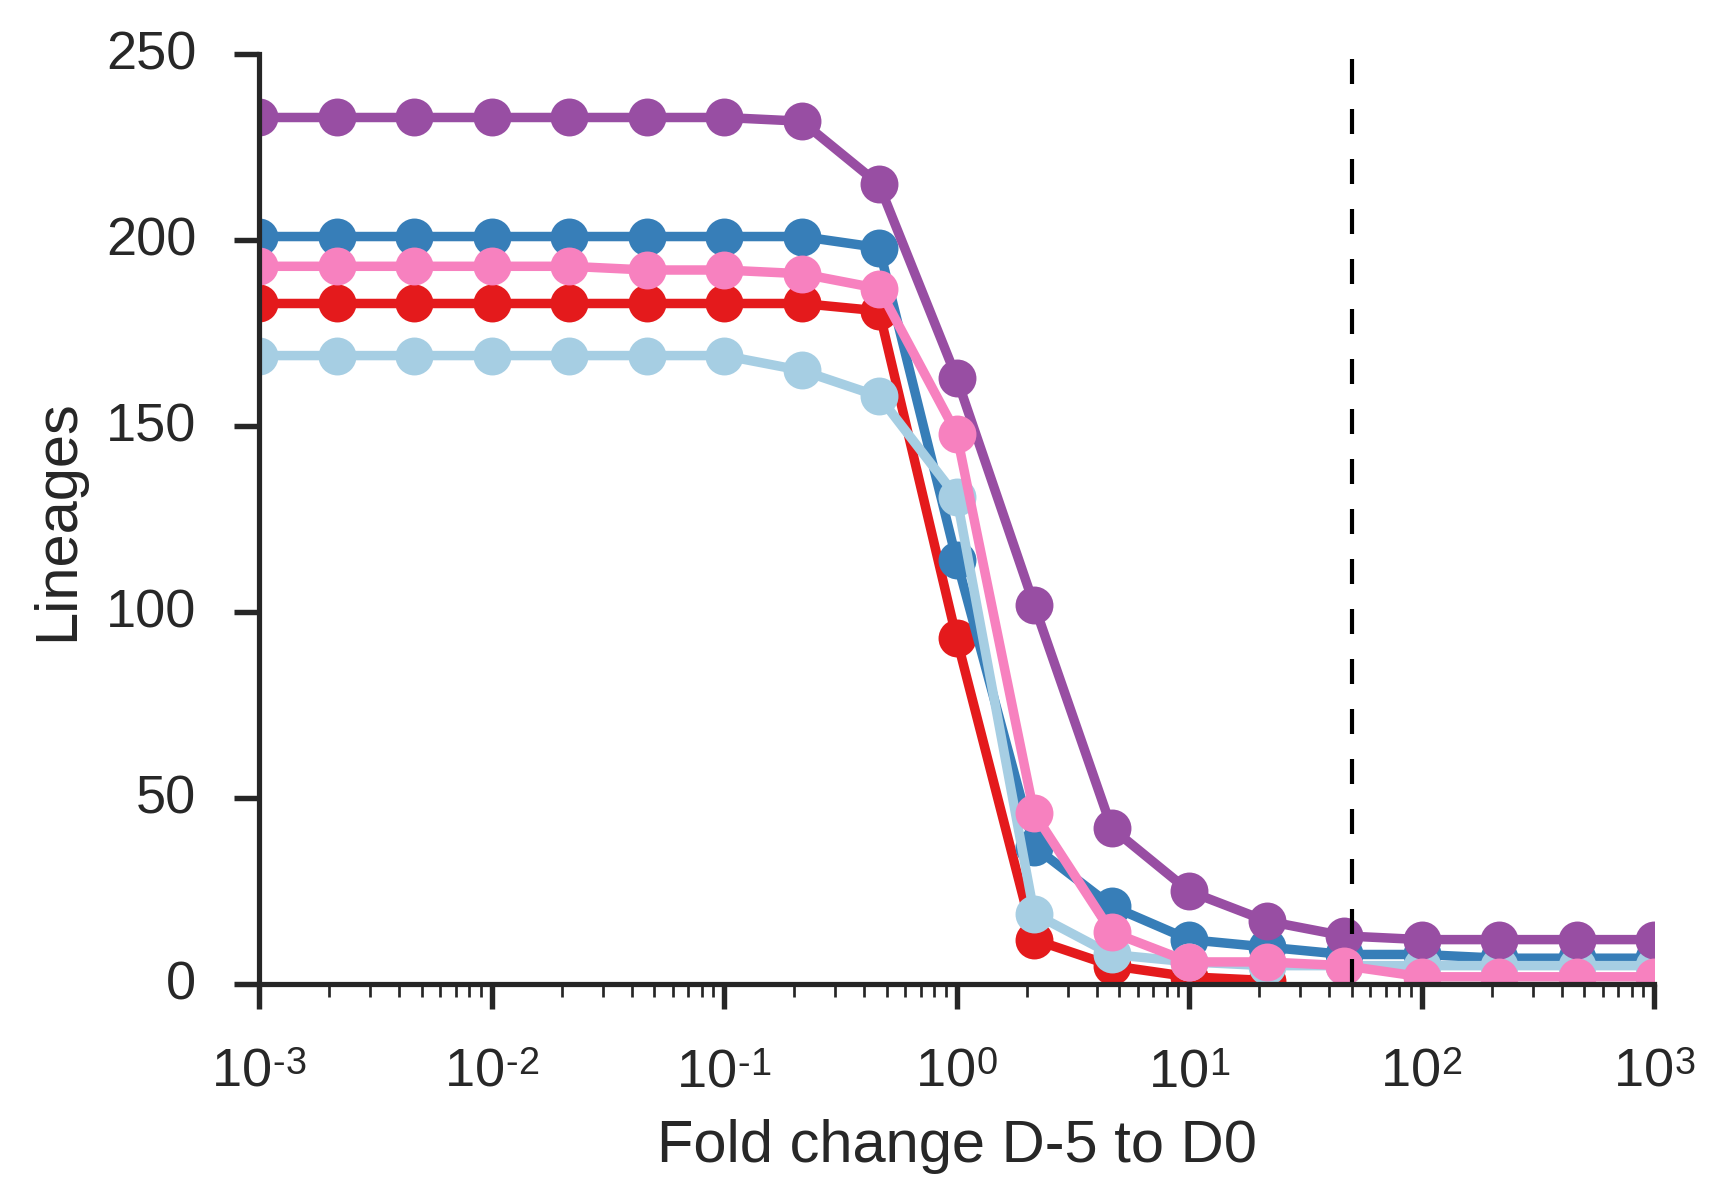

In [107]:
# Count lineages upregulated (activated) as a function of cutoff
ratio_cutoffs = np.logspace(-3,3,19)

# Choose cutoff of fractional abundance for inclusion
sequences_V3_normed_cutoff = 0.001
# sequences_V3_cutoff = 50

df_lineagesActivated_V3_V1_ratio = pd.DataFrame()
for myCutoff in ratio_cutoffs:
    myDf = df_all.loc[np.logical_and(df_all["V3_V1_ratio"] > myCutoff,
                                     df_all["sequences_V3_normed"] > sequences_V3_normed_cutoff)]
#     myDf = df_all.loc[np.logical_and(df_all["V3_V1_ratio"] > myCutoff,
#                                      df_all["sequences_V3"] > sequences_V3_cutoff)]
    counts = myDf["patient_uid"].value_counts()
    df_lineagesActivated_V3_V1_ratio = df_lineagesActivated_V3_V1_ratio.append(counts, ignore_index=True)
df_lineagesActivated_V3_V1_ratio["cutoff"] = ratio_cutoffs
df_lineagesActivated_V3_V1_ratio.set_index("cutoff", inplace=True)

# Plot
sns.set_palette(myColors_subjects)
fig, ax = plt.subplots(1, 1, figsize=(6,4))
df_lineagesActivated_V3_V1_ratio.plot(ax=ax, marker="o")
ax.axvline(50, ls="--", c="k", lw=1)
ax.set_xscale("log")
ax.set_xlabel("Fold change D-5 to D0")
ax.set_ylabel("Lineages")
ax.legend_.remove()
sns.despine()
save_figure(fig, "ClonalLineageDynamics_DeterminingCutoff_V3V1ratio", output_dir, output_suffix, output_formats, savefig_args)

# Report number of lineages as table
df_lineagesActivated_V3_V1_ratio

In [108]:
# Report summary statistics
x = df_lineagesActivated_V3_V1_ratio.iloc[-5]
x[np.isnan(x)] = 0

print "Number of lineages per person passing fold-change cutoff between D-5 and D0"
print "mean", np.mean(x)
print "std", np.std(x)

Number of lineages per person passing fold-change cutoff between D-5 and D0
mean 6.2
std 4.26145515053


In [109]:
# How many actual sequences does the abundance cutoff correspond to?
for patient_uid, group in df_all.groupby("patient_uid"):
    print patient_uid, sum(group.sequences_V3), sum(group.sequences_V3) * sequences_V3_normed_cutoff

2 51607.0 51.607
3 64591.0 64.591
6 25588.0 25.588
7 5233.0 5.233
8 31081.0 31.081


Statistics of fold change
Mean 2.30644930637
STD 6.13319969386


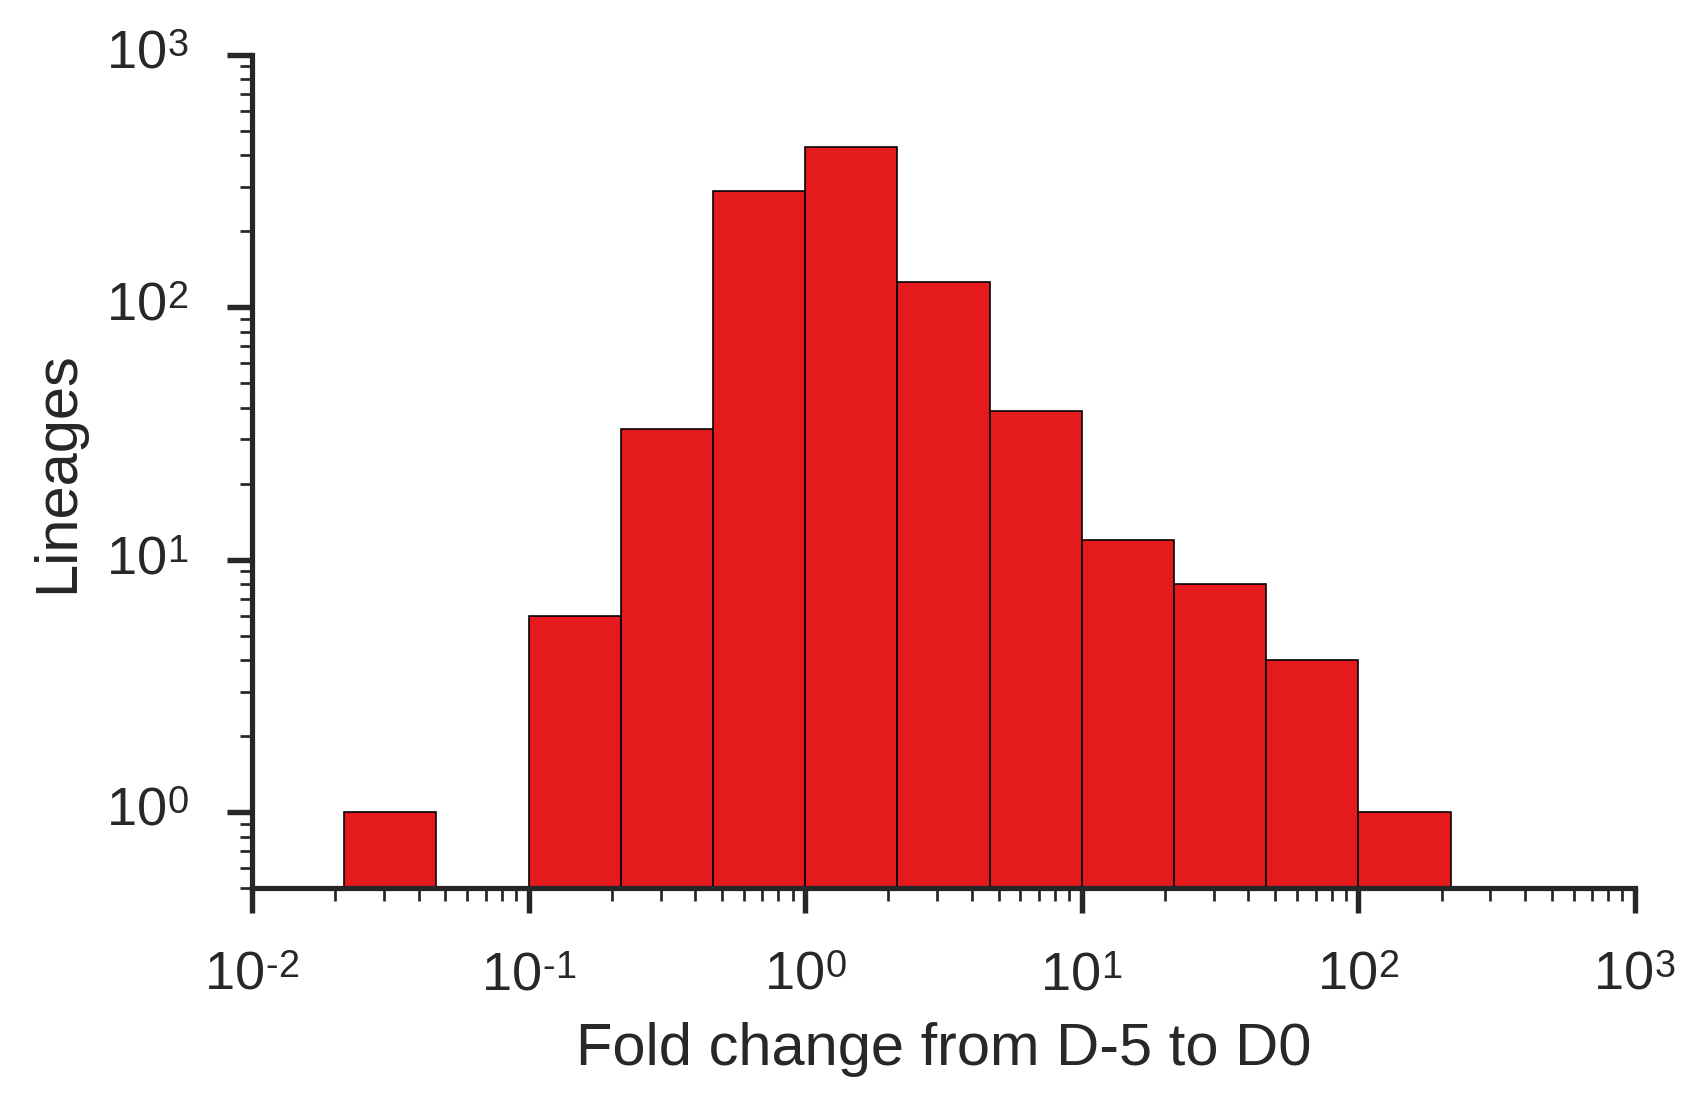

In [110]:
# Plot distribution of fold change values between baseline time points

x = copy.deepcopy(df_all.loc[df_all["sequences_V3_normed"] > sequences_V3_normed_cutoff]["V3_V1_ratio"])
x[np.isinf(x)] = 0
x[np.isnan(x)] = 0

bins = np.logspace(-2, 3, 16)

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(list(x), bins=bins)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(bottom=0.5)
ax.set_xlabel("Fold change from D-5 to D0")
ax.set_ylabel("Lineages")
sns.despine()
plt.tight_layout()
save_figure(fig, "ClonalLineageDynamics_DeterminingCutoff_V3V1ratioHistogram", output_dir, output_suffix, output_formats, savefig_args)

print "Statistics of fold change"
print "Mean", np.mean(x)
print "STD", np.std(x)

# Identify vaccine-responsive and persistent lineages

In [111]:
# Set cutoffs
V6_V3_ratio_cutoff = 50
sequences_V6_normed_cutoff = 0.001

In [112]:
# Define sets of lineages by dynamics
df_expanded = df_all.loc[np.logical_and(df_all["V6_V3_ratio"] > V6_V3_ratio_cutoff,
                                        df_all["sequences_V6_normed"] > sequences_V6_normed_cutoff)]
df_persistent = df_all.loc[np.logical_and(df_all["V6_V3_ratio"] <= 2,
                                          df_all["sequences_V6_normed"] > sequences_V6_normed_cutoff)]

print "Number of lineages"
print "Expanded", df_expanded.shape[0]
print "Persistent", df_persistent.shape[0]

Number of lineages
Expanded 182
Persistent 417


In [113]:
# Report number of lineages per subject
print "Expanded"
print df_expanded["patient_uid"].value_counts()
print np.mean(df_expanded["patient_uid"].value_counts())
print np.std(df_expanded["patient_uid"].value_counts())
print
print "Persistent"
print df_persistent["patient_uid"].value_counts()
print np.mean(df_persistent["patient_uid"].value_counts())
print np.std(df_persistent["patient_uid"].value_counts())

Expanded
6    49
7    45
8    40
3    32
2    16
Name: patient_uid, dtype: int64
36.4
11.6721891691

Persistent
2    111
3     97
8     89
7     76
6     44
Name: patient_uid, dtype: int64
83.4
22.7385135838


In [115]:
print "Fraction of repertoire at D7 composed of..."
print
print "Vaccine-responsive"
print
Z = []
for patient_uid in [2, 3, 6, 7, 8]:
    z = sum(df_expanded[df_expanded["patient_uid"] == patient_uid]["sequences_V6_normed"])
    Z.append(z)
    print "Patient " + str(patient_uid) + ": " + str(z)

print
print "mean", np.mean(Z)
print "std", np.std(Z)

Z = []
print
print "Persistent"
print
for patient_uid in [2, 3, 6, 7, 8]:
    z = sum(df_persistent[df_persistent["patient_uid"] == patient_uid]["sequences_V6_normed"])
    Z.append(z)
    print "Patient " + str(patient_uid) + ": " + str(z)

print
print "mean", np.mean(Z)
print "std", np.std(Z)

Fraction of repertoire at D7 composed of...

Vaccine-responsive

Patient 2: 0.224931463836
Patient 3: 0.139717049733
Patient 6: 0.237085288648
Patient 7: 0.436528709308
Patient 8: 0.100917159763

mean 0.227835934258
std 0.11620668999

Persistent

Patient 2: 0.326425371061
Patient 3: 0.248672232399
Patient 6: 0.106613218729
Patient 7: 0.171151644037
Patient 8: 0.254289940828

mean 0.221430481411
std 0.0755734731507


In [116]:
# Write dataframes to file
df_expanded.to_csv("data/df_expanded.csv")
df_persistent.to_csv("data/df_persistent.csv")

# Plot dynamics of vaccine-responsive and persistent lineages

In [117]:
# Define plotting parameters and functions

def plot_pretty_time_series(df, labels, N, color, ax):
#    sns.set_palette(sns.dark_palette(color, n_colors=N, input="rgb", reverse=True))
    for i in range(N):
        x = labels
        y = df.iloc[i]
#        c = cmap(float(i) / float(N))
        ax.plot(x, y, marker=".", markersize=5, lw=1)
    
col_names = ["sequences_V" + str(x) + "_normed" for x in range(1, 9)] # columns to plot
days = [-5, -3, 0, 1, 4, 7, 9, 11] # days of samples (for labeling xticks)

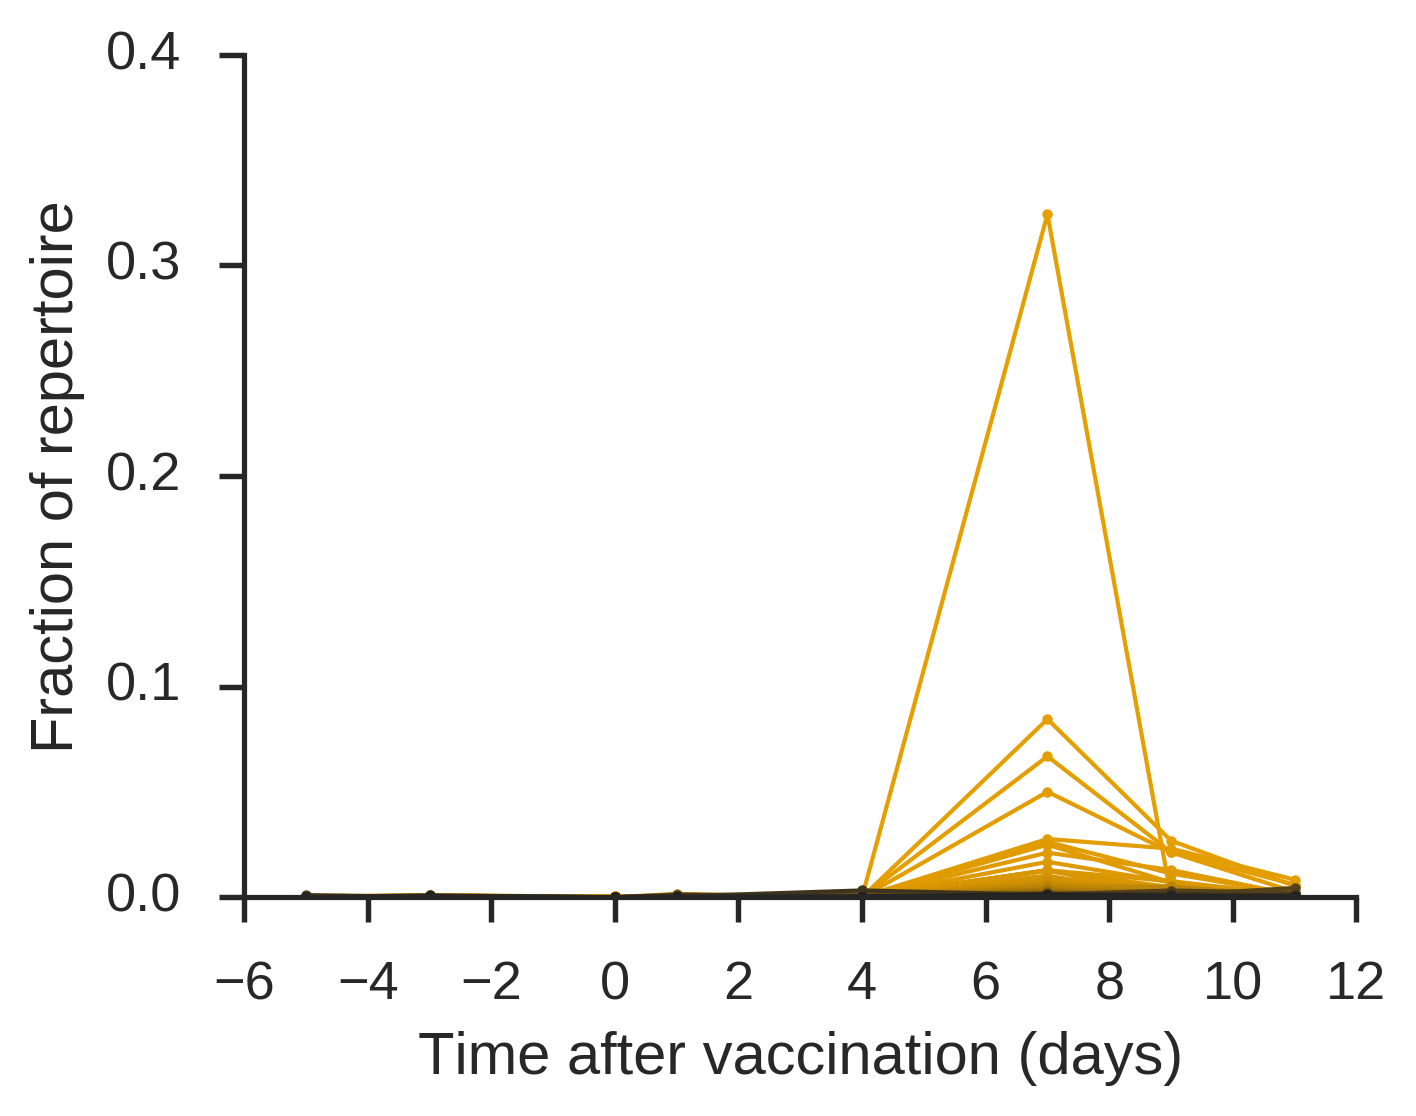

In [118]:
# Vaccine-responsive lineages

myDf = copy.deepcopy(df_expanded)
myDf = myDf[col_names]
myDf[myDf == 0.] = 1e-6 # replace 0 values with 1e-6 to show not detected (ND)

N = myDf.shape[0] # number of lineages to show
sns.set_palette(sns.dark_palette(myColors[0], n_colors=N, input="rgb", reverse=True))

fig, ax = plt.subplots(1, 1, figsize=(5,4))
plot_pretty_time_series(myDf, days, N=N, color=myColors[1], ax=ax)
ax.set_ylim([0, 0.4])
ax.set_xlabel("Time after vaccination (days)")
ax.set_ylabel("Fraction of repertoire")
plt.locator_params(axis='y',nbins=4)
sns.despine()
plt.tight_layout()
save_figure(fig, "ClonalLineageDynamics_Dynamics_expanded", output_dir, output_suffix, output_formats, savefig_args)

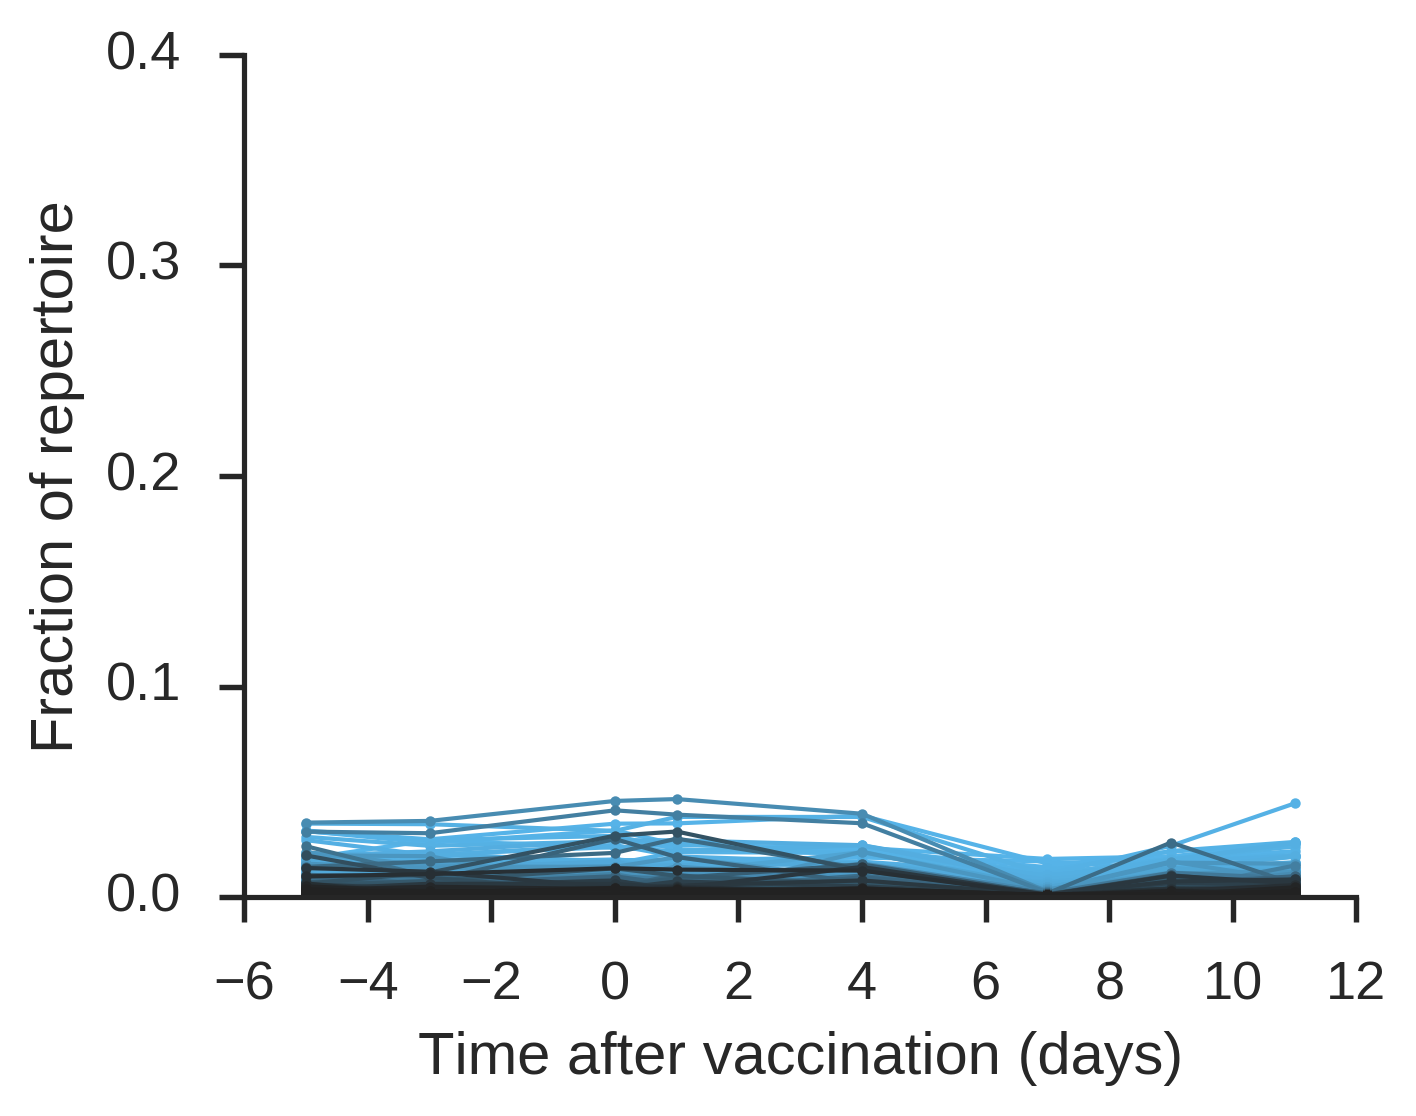

In [119]:
# Persistent lineages

myDf = copy.deepcopy(df_persistent)
myDf = myDf[col_names]
myDf[myDf == 0.] = 1e-6 # replace 0 values with 1e-6 to show not detected (ND)

N = myDf.shape[0] # number of lineages to show
sns.set_palette(sns.dark_palette(myColors[1], n_colors=N, input="rgb", reverse=True))

fig, ax = plt.subplots(1, 1, figsize=(5,4))
plot_pretty_time_series(myDf, days, N=N, color=myColors[1], ax=ax)
ax.set_ylim([0, 0.4])
ax.set_xlabel("Time after vaccination (days)")
ax.set_ylabel("Fraction of repertoire")
plt.locator_params(axis='y',nbins=4)
sns.despine()
plt.tight_layout()
save_figure(fig, "ClonalLineageDynamics_Dynamics_persistent", output_dir, output_suffix, output_formats, savefig_args)

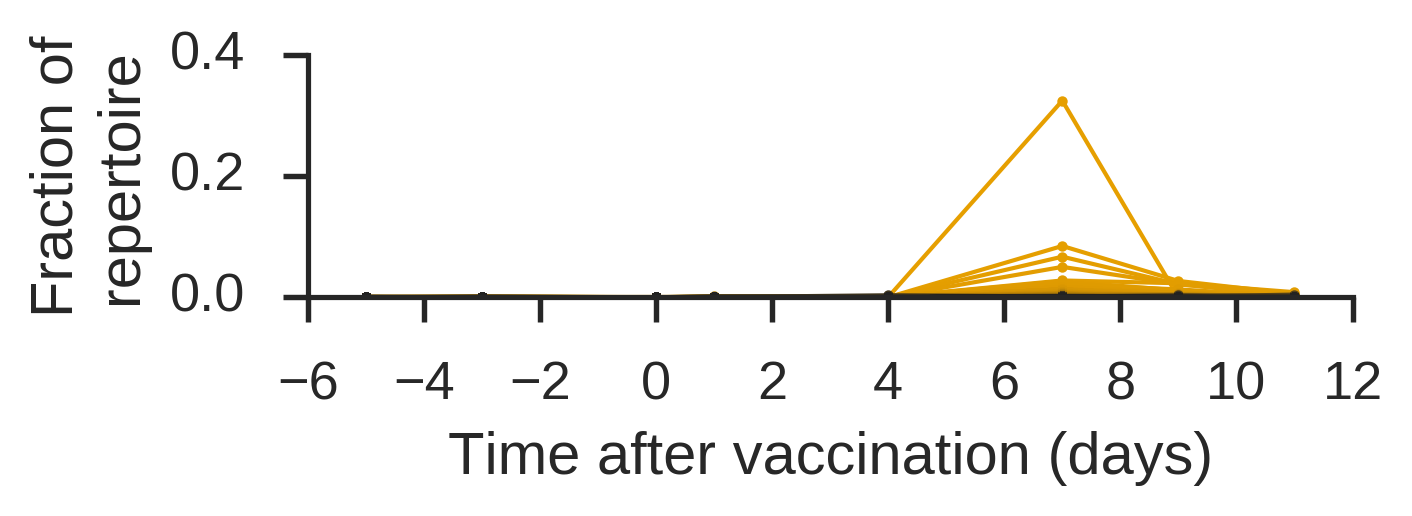

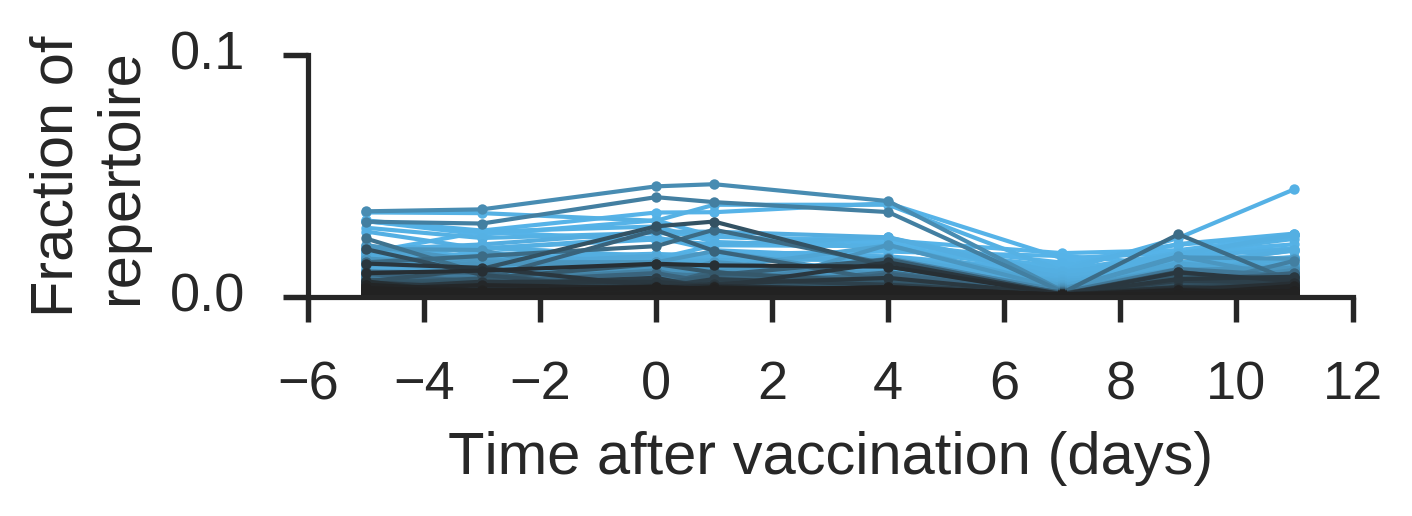

In [134]:
# Same plots but flatter aspect ratio

# Vaccine-responsive lineages

myDf = copy.deepcopy(df_expanded)
myDf = myDf[col_names]
myDf[myDf == 0.] = 1e-6 # replace 0 values with 1e-6 to show not detected (ND)

N = myDf.shape[0] # number of lineages to show
sns.set_palette(sns.dark_palette(myColors[0], n_colors=N, input="rgb", reverse=True))

fig, ax = plt.subplots(1, 1, figsize=(5,2))
plot_pretty_time_series(myDf, days, N=N, color=myColors[1], ax=ax)
ax.set_ylim([0, 0.4])
ax.set_yticks([0, 0.2, 0.4])
ax.set_xlabel("Time after vaccination (days)")
ax.set_ylabel("Fraction of\nrepertoire")
# plt.locator_params(axis='y',nbins=4)
sns.despine()
plt.tight_layout()
save_figure(fig, "ClonalLineageDynamics_Dynamics_expanded_flat", output_dir, output_suffix, output_formats, savefig_args)

# Persistent lineages

myDf = copy.deepcopy(df_persistent)
myDf = myDf[col_names]
myDf[myDf == 0.] = 1e-6 # replace 0 values with 1e-6 to show not detected (ND)

N = myDf.shape[0] # number of lineages to show
sns.set_palette(sns.dark_palette(myColors[1], n_colors=N, input="rgb", reverse=True))

fig, ax = plt.subplots(1, 1, figsize=(5,2))
plot_pretty_time_series(myDf, days, N=N, color=myColors[1], ax=ax)
ax.set_ylim([0, 0.1])
ax.set_yticks([0, 0.1])
ax.set_xlabel("Time after vaccination (days)")
ax.set_ylabel("Fraction of\nrepertoire")
# plt.locator_params(axis='y',nbins=4)
sns.despine()
plt.tight_layout()
save_figure(fig, "ClonalLineageDynamics_Dynamics_persistent_flat", output_dir, output_suffix, output_formats, savefig_args)

Expanded
Mean 2.08923503715
STD 0.451391492716

Persistent
Mean 0.360990216945
STD 0.186451179161


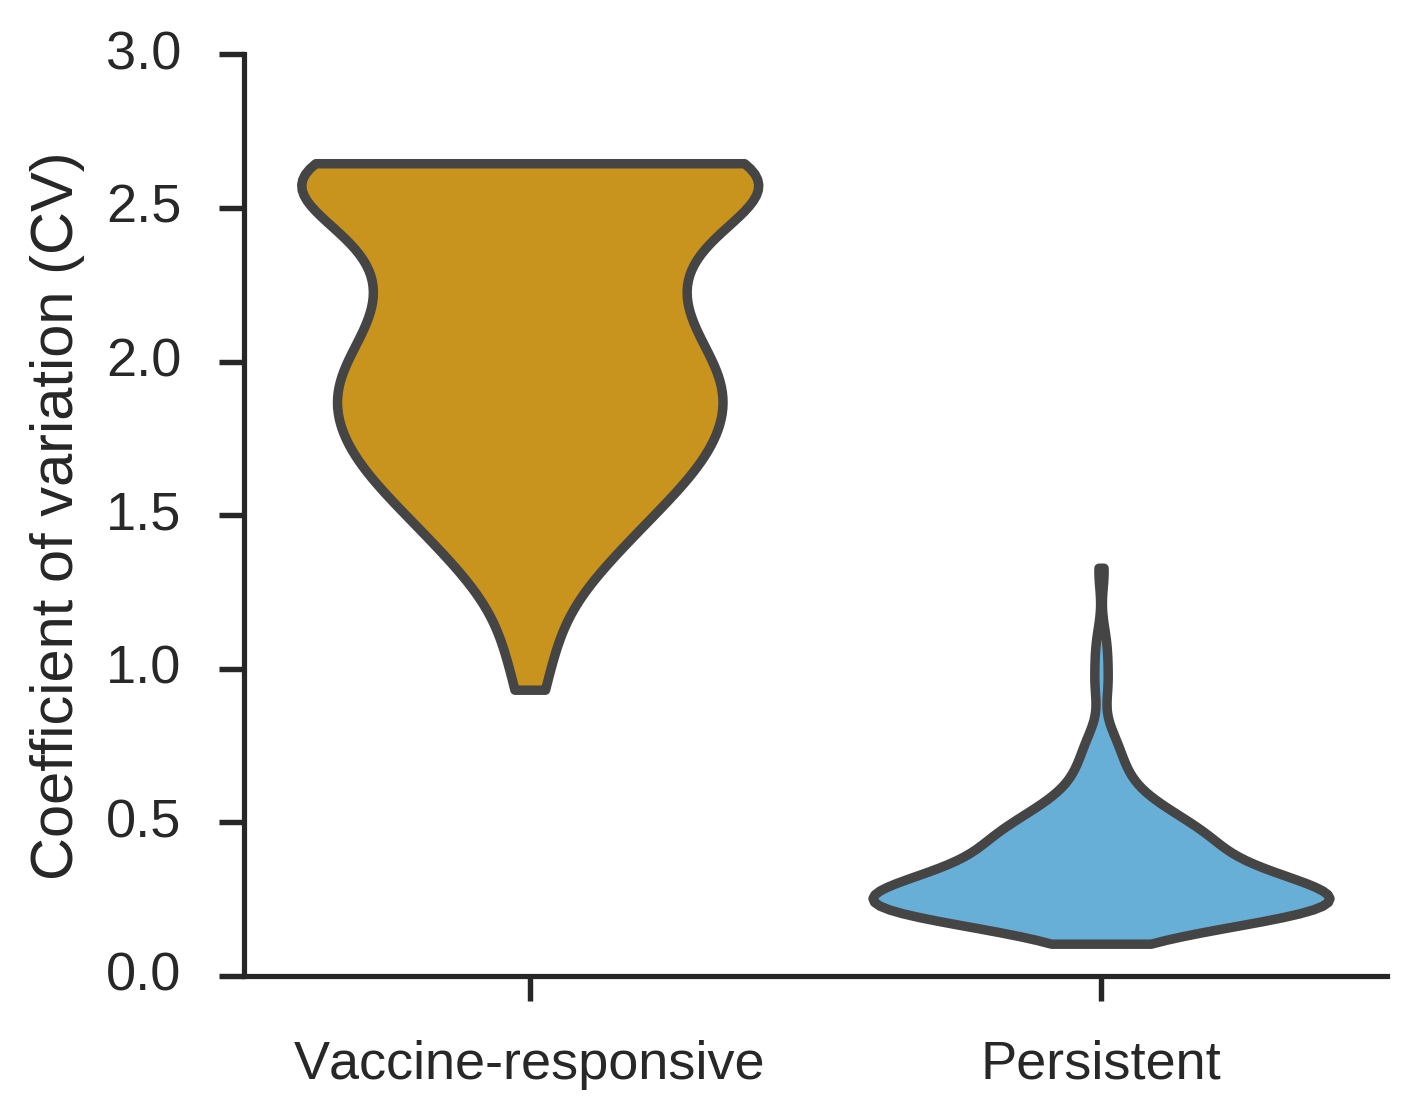

In [120]:
# Variability of abundance (CV)
x = scipy.stats.variation(df_expanded[col_names], axis=1)
y = scipy.stats.variation(df_persistent[col_names], axis=1)
data = [x, y]

fig, ax = plt.subplots(1, 1, figsize=(5,4))
sns.violinplot(data=data, cut=0, inner=None, orient="v", ax=ax, palette=myColors, width=0.8, scale="width")
ax.set_xticklabels(["Vaccine-responsive", "Persistent"], rotation=0, ha="center")
ax.set_ylabel("Coefficient of variation (CV)")
sns.despine()
plt.tight_layout()
save_figure(fig, "ClonalLineageDynamics_Dynamics_CV", output_dir, output_suffix, output_formats, savefig_args)

print "Expanded"
print "Mean", np.mean(x)
print "STD", np.std(x)
print
print "Persistent"
print "Mean", np.mean(y)
print "STD", np.std(y)

# Sensitivity to parameters (fold-change cutoff, abundance cutoff)

In [121]:
# Reformat data
myDf = df_all.loc[np.logical_and(df_all["V6_V3_ratio"] > V6_V3_ratio_cutoff, df_all["sequences_V6_normed"] > sequences_V6_normed_cutoff)]
myDf = myDf[col_names]
myDf[myDf == 0.] = 1e-6 # replace 0 values with 1e-6 to show not detected (ND)
myDf_high = myDf

myDf = df_all.loc[np.logical_and(df_all["V6_V3_ratio"] <= V6_V3_ratio_cutoff, df_all["sequences_V6_normed"] > sequences_V6_normed_cutoff)]
myDf = myDf[col_names]
myDf[myDf == 0.] = 1e-6 # replace 0 values with 1e-6 to show not detected (ND)
myDf_low = myDf

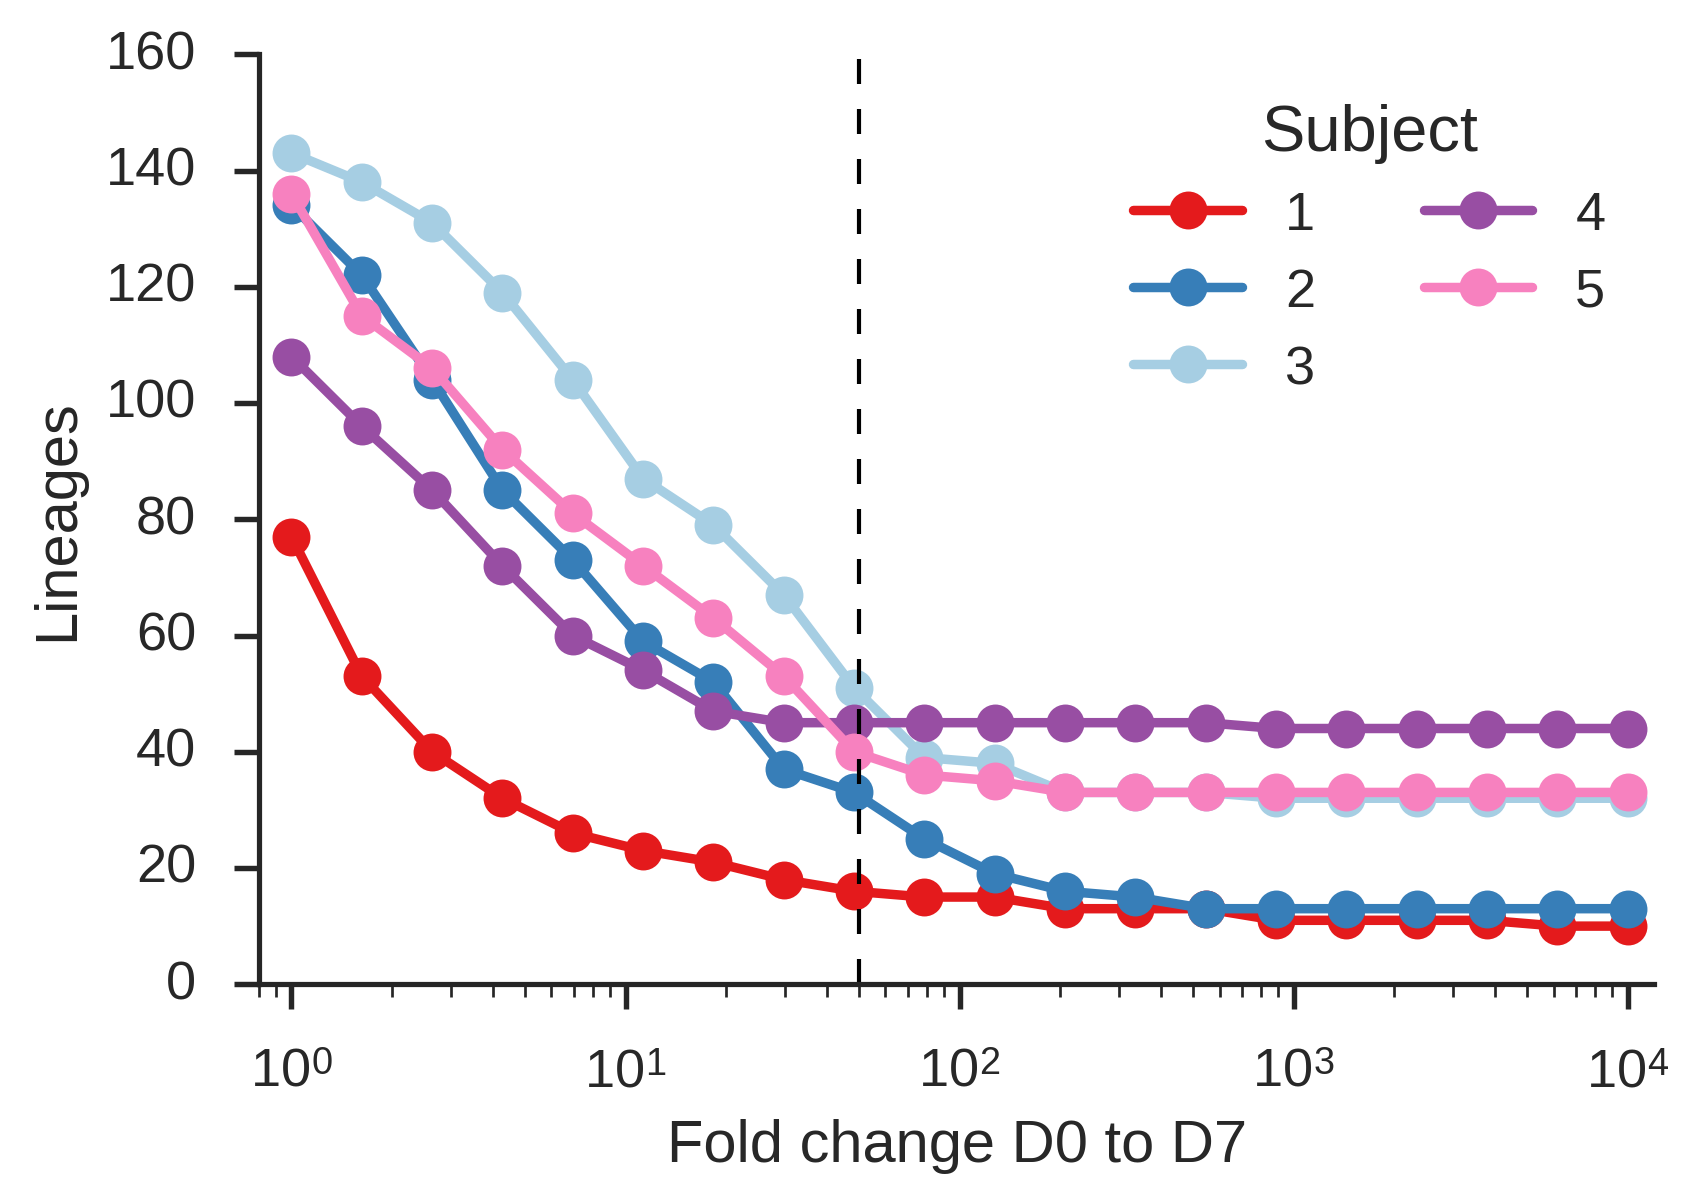

In [124]:
# Count lineages responding at various cutoffs (fold change)
V6_V3_ratio_cutoffs = np.logspace(0,4,20)
df_lineagesActivated_V6_V3_ratio = pd.DataFrame()
for myCutoff in V6_V3_ratio_cutoffs:
    myDf = df_all.loc[np.logical_and(df_all["V6_V3_ratio"] > myCutoff, df_all["sequences_V6_normed"] > sequences_V6_normed_cutoff)]
    counts = myDf["patient_uid"].value_counts()
    df_lineagesActivated_V6_V3_ratio = df_lineagesActivated_V6_V3_ratio.append(counts, ignore_index=True)
df_lineagesActivated_V6_V3_ratio["cutoff"] = V6_V3_ratio_cutoffs
df_lineagesActivated_V6_V3_ratio.set_index("cutoff", inplace=True)

# Plot lineages responding as a function of fold change cutoff
sns.set_palette(myColors_subjects)
fig, ax = plt.subplots(1, 1, figsize=(6,4))
df_lineagesActivated_V6_V3_ratio.plot(ax=ax, marker="o")
ax.axvline(V6_V3_ratio_cutoff, ls="--", c="k", lw=1)
# ax.plot((10,10),(0,160),"k--")
ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_ylim([0,160])
ax.set_xlim([0.8, 1.2e4])
ax.set_xlabel("Fold change D0 to D7")
ax.set_ylabel("Lineages")
ax.legend(loc="upper right", ncol=2, labels=["1", "2", "3", "4", "5"], title="Subject")
# ax.legend_.remove()
sns.despine()
save_figure(fig, "ClonalLineageDynamics_DeterminingCutoff_FoldChangeCutoff", output_dir, output_suffix, output_formats, savefig_args)

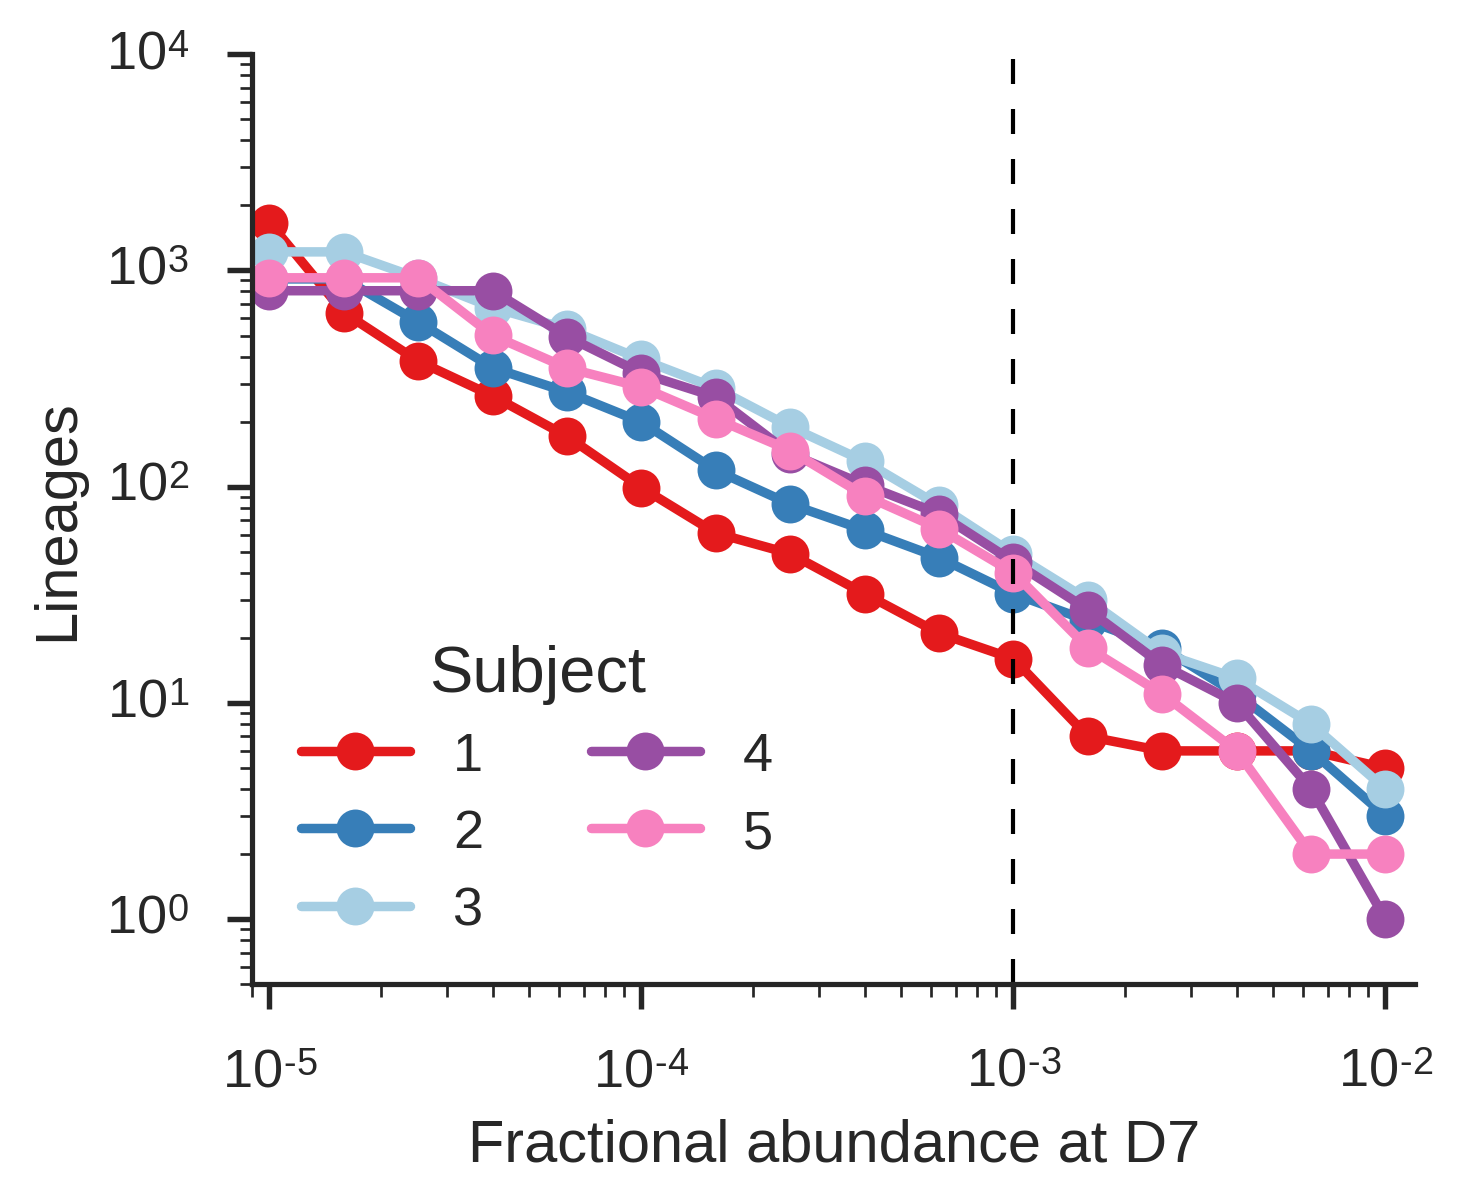

In [127]:
# Count lineages responding at various cutoffs (relative abundance)
sequences_V6_normed_cutoffs = np.logspace(-5,-2,16)
df_lineagesActivated_sequences_V6_normed = pd.DataFrame()
for myCutoff in sequences_V6_normed_cutoffs:
    myDf = df_all.loc[np.logical_and(df_all["V6_V3_ratio"] > V6_V3_ratio_cutoff, df_all["sequences_V6_normed"] > myCutoff)]
    counts = myDf["patient_uid"].value_counts()
    df_lineagesActivated_sequences_V6_normed = df_lineagesActivated_sequences_V6_normed.append(counts, ignore_index=True)
df_lineagesActivated_sequences_V6_normed["cutoff"] = sequences_V6_normed_cutoffs
df_lineagesActivated_sequences_V6_normed.set_index("cutoff", inplace=True)

# Plot lineages responding as a function of relative abundance cutoff
sns.set_palette(myColors_subjects)
fig, ax = plt.subplots(1, 1, figsize=(5,4))
df_lineagesActivated_sequences_V6_normed.plot(ax=ax, marker="o")
ax.axvline(sequences_V6_normed_cutoff, ls="--", c="k", lw=1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(bottom=0.5)
ax.set_xlim([0.9e-5, 1.2e-2])
ax.set_xlabel("Fractional abundance at D7")
ax.set_ylabel("Lineages")
ax.legend(ncol=2, labels=["1", "2", "3", "4", "5"], title="Subject", loc="lower left")
sns.despine()
save_figure(fig, "ClonalLineageDynamics_DeterminingCutoff_FractionalAbundanceCutoff", output_dir, output_suffix, output_formats, savefig_args)